### Preparing data and queries

* Schema & queries from here: https://github.com/gregrahn/join-order-benchmark
* Data from here: https://event.cwi.nl/da/job/
  * Download imdb.tgz
  * Unpack into data/imdb
  * Run [job_data_cleanup.ipynb](job_data_cleanup.ipynb)


Commands to create database and schema and load data:
```
createdb job
psql job -f schema/job_postgres.sql 
psql job -f schema/job_load_data.sql
psql job -f schema/job_fkindexes.sql

createdb job_columnar
psql job_columnar -f schema/job_postgres_columnar.sql 
psql job_columnar -f schema/job_load_data.sql
psql job_columnar -f schema/job_fkindexes.sql
```


In [1]:
import pandas as pd
import json
from diskcache import Cache
from matplotlib import pyplot as plt
import psycopg2
import time
import numpy as np

### Connecting to both databases

In [2]:
db_user = "postgres"
db_password = "admin"
db_host = "localhost"
db_port = 5432
db_name_1 = "job"
db_name_2 = "job_columnar"

conn1 = psycopg2.connect(f"dbname='{db_name_1}' user='{db_user}' host='{db_host}' password='{db_password}'")
conn2 = psycopg2.connect(f"dbname='{db_name_2}' user='{db_user}' host='{db_host}' password='{db_password}'")
print("OK")

OK


### Table sizes

In [3]:
sizes_query = """
SELECT tablename, pg_total_relation_size(quote_ident(tablename)) AS size
FROM pg_catalog.pg_tables
WHERE schemaname = 'public'
ORDER BY tablename
"""

with conn1.cursor() as cur:
    cur.execute(sizes_query)
    sizes1 = cur.fetchall()

with conn2.cursor() as cur:
    cur.execute(sizes_query)
    sizes2 = cur.fetchall()

sizes=[]
total_size_row = 0
total_size_col = 0
for i in range(len(sizes1)):
    assert sizes1[i][0]==sizes2[i][0]
    sizes.append([sizes1[i][0],sizes1[i][1],sizes2[i][1],sizes1[i][1]/sizes2[i][1]])
    total_size_row += sizes1[i][1]
    total_size_col += sizes2[i][1]
    
df=pd.DataFrame(sizes,columns=['Table name', 'Size in row-based (B)', 'Size in columnar (B)', 'Compresison ratio'])
df=df.style.hide(axis="index")
df
print(f"Total size, row-store: {total_size_row} B")
print(f"Total size, columnar: {total_size_col} B")
ratio = total_size_row / total_size_col
print(f"Ratio: {ratio:0.2f}")

Total size, row-store: 9114861568 B
Total size, columnar: 5030674432 B
Ratio: 1.81


### Comparing query execution time

In [4]:
cache = Cache("~/db-experiments-cache/job")

@cache.memoize()
def run_experiment(query_path, store_type, run_id=0):
    # Returns query execution time in seconds.
    assert store_type in ["row", "columnar"]
    with open(query_path) as f:
        query = f.read()
    conn = conn1 if store_type == "row" else conn2
    print(f"{query_path} {store_type} run {run_id}...")
    t0=time.time()
    with conn.cursor() as cur:
        cur.execute(query)
        cur.fetchall()
    return time.time()-t0

# exclude 15 because uses view.
# exclude 17,20,21 because took too long (didn't complete in 5 minutes on row store).
query_ids = ['1a','1b','1c','1d','2a','2b','2c','2d',
             '3a','3b','3c','4a','4b','4c','5a','5b','5c',
             '6a','6b','6c','6d','6e','6f',
             '7a','7b','7c','8b','8c','8d']

results = dict()
for query_id in query_ids:
    query_path = f'queries/job/{query_id}.sql'
    for store_type in ['row', 'columnar']:
        res = [run_experiment(query_path, store_type, run_id=run_id) for run_id in range(5)]
        print(query_id, store_type, res)
        results[(query_id, store_type)] = res



1a row [0.09576845169067383, 0.03676414489746094, 0.03829193115234375, 0.03993415832519531, 0.03945326805114746]
1a columnar [26.032499313354492, 24.778090715408325, 23.964965343475342, 24.35942053794861, 23.38963747024536]
1b row [0.044631004333496094, 0.035645484924316406, 0.037293434143066406, 0.037358760833740234, 0.03748965263366699]
1b columnar [1.034015417098999, 0.9741013050079346, 0.956932783126831, 0.9467015266418457, 0.9510235786437988]
1c row [0.03869223594665527, 0.039427757263183594, 0.037339210510253906, 0.03956246376037598, 0.03960537910461426]
1c columnar [12.465986013412476, 12.49011492729187, 12.29692530632019, 12.292203903198242, 12.524895906448364]
1d row [0.03626227378845215, 0.037380218505859375, 0.038220882415771484, 0.03875565528869629, 0.03825044631958008]
1d columnar [0.8449373245239258, 0.8403189182281494, 0.8394031524658203, 0.8391463756561279, 0.8444302082061768]
2a row [1.55322265625, 0.3324854373931885, 0.3461329936981201, 0.34252166748046875, 0.33858180

In [5]:
results_table = []
row_means, row_std = [], []
col_means, col_std = [], []
query_names=[]

for query_id in query_ids:
    query_name = f"{query_id}"
    mean_row, std_row = np.mean(results[(query_id, 'row')][1:]), np.std(results[(query_id, 'row')][1:])
    mean_col, std_col = np.mean(results[(query_id, 'columnar')][1:]), np.std(results[(query_id, 'columnar')][1:])    
    row_means.append(mean_row)
    row_std.append(std_row)
    col_means.append(mean_col)
    col_std.append(std_col)
    query_names.append(query_name)
    
    ratio = mean_row/mean_col
    results_table += [[
        query_name,
        f"{mean_row:0.1f}±{std_row:0.1f}",
        f"{mean_col:0.1f}±{std_col:0.1f}",
        f"{ratio:0.3f}"
    ]]

header=["Query", "Row-store time (sec)","Columnar time (sec)","Speedup"]
df=pd.DataFrame(results_table,columns=header)
df=df.style.hide(axis="index")
df

Query,Row-store time (sec),Columnar time (sec),Speedup
1a,0.0±0.0,24.1±0.5,0.002
1b,0.0±0.0,1.0±0.0,0.039
1c,0.0±0.0,12.4±0.1,0.003
1d,0.0±0.0,0.8±0.0,0.045
2a,0.3±0.0,1.2±0.0,0.283
2b,0.3±0.0,1.2±0.0,0.269
2c,0.3±0.0,1.2±0.0,0.266
2d,0.5±0.0,1.3±0.0,0.359
3a,0.1±0.0,3.4±0.1,0.039
3b,0.1±0.0,2.1±0.0,0.039


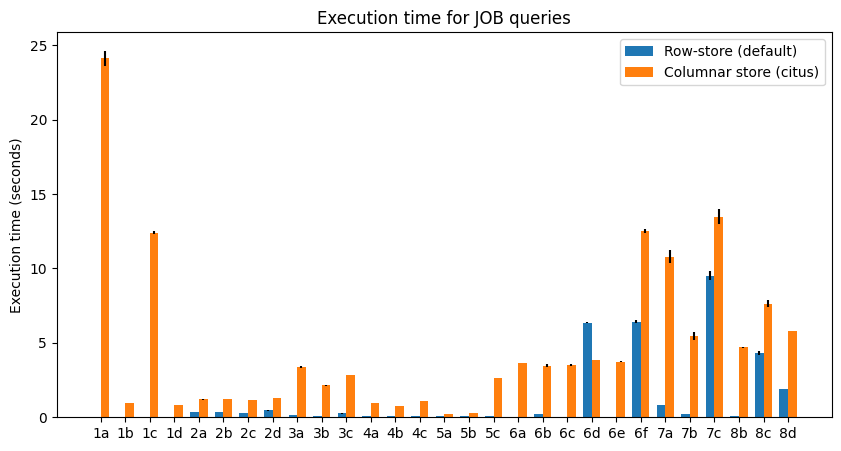

In [6]:
ind = np.arange(len(query_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(ind - width/2, row_means, width, yerr=row_std,
                label='Row-store (default)')
rects2 = ax.bar(ind + width/2, col_means, width, yerr=col_std,
                label='Columnar store (citus)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution time (seconds)')
ax.set_title('Execution time for JOB queries')
ax.set_xticks(ind)
ax.set_xticklabels(query_names)
ax.legend()
plt.savefig('img/results-job.png')
plt.show()

In [7]:
conn1.close()
conn2.close()